In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

In [2]:
from helper import *
from copy import deepcopy

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 42

Using device: cuda
CUDA device: NVIDIA GeForce RTX 4060 Ti
CUDA memory: 16.0 GB


In [3]:
# RGB to HSV Network
class RGBtoHSVNet(nn.Module):
    def __init__(self):
        super(RGBtoHSVNet, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 3)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
base_epochs = 50
extra_epochs = 1
index = 1
k = 5

# RGB-HSV Dataset
rgb_train = generate_rgb_samples(1000, device=device, seed=42)
hsv_train = rgb_to_hsv(rgb_train)

rgb_test = generate_rgb_samples(250, device=device, seed=42)
hsv_test = rgb_to_hsv(rgb_test)

rgb_train_loader = DataLoader(TensorDataset(rgb_train.cpu(), hsv_train.cpu()), batch_size=64, shuffle=False)
rgb_test_loader = DataLoader(TensorDataset(rgb_test.cpu(), hsv_test.cpu()), batch_size=64, shuffle=False)

# Training Base Model:
rgb_model = RGBtoHSVNet()
rgb_criterion = nn.MSELoss()
rgb_optimizer = optim.Adam(rgb_model.parameters(), lr=0.001)
rgb_losses, trained_rgb = train_model(rgb_model, rgb_train_loader, rgb_criterion, rgb_optimizer, num_epochs=base_epochs, seed=42, verbose=False)
print(rgb_losses[-1:])

# Training one more Epoch
rgb_model_v2 = RGBtoHSVNet()
rgb_criterion = nn.MSELoss()
rgb_optimizer = optim.Adam(rgb_model_v2.parameters(), lr=0.001)
rgb_losses_v2, trained_rgb_v2 = train_model(rgb_model_v2, rgb_train_loader, rgb_criterion, rgb_optimizer, num_epochs=base_epochs+extra_epochs, seed=17, verbose=False, continue_training=False)
print(rgb_losses_v2[-1:])

rgb_inputs, rgb_activations, rgb_outputs = get_activations(trained_rgb, rgb_train_loader, dataset_type='rgb_hsv') # Full Network capture
single_rgb_inputs, single_rgb_activations, single_rgb_outputs = get_activations(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index) # Single Sample capture

indices_rgb, distances_rgb = find_knn(rgb_activations, single_rgb_activations, k=k, metric='cosine') # Finding KNN - Cosine
filtered_rgb_loader, filtered_size = create_filtered_dataloader(rgb_train_loader, exclude_indices=indices_rgb, batch_size=64, shuffle=False)
print(f"KNN Indices (Cosine): {indices_rgb}")
print(f"KNN Distances (Cosine): {distances_rgb}")

# Train a new clean model
filtered_rgb_model = RGBtoHSVNet()
rgb_optimizer_filter = optim.Adam(filtered_rgb_model.parameters(), lr=0.0001)
rgb_losses_filtered, filtered_rgb = train_model(filtered_rgb_model, rgb_train_loader, rgb_criterion, rgb_optimizer_filter, num_epochs=base_epochs, seed=42, verbose=False, continue_training=False)
print(rgb_losses_filtered[-1:])

# Extra Epoch with filtered data
rgb_losses_filtered_v2, filtered_rgb_v2 = train_model(filtered_rgb_model, filtered_rgb_loader, rgb_criterion, rgb_optimizer_filter, num_epochs=extra_epochs, seed=42, verbose=False, continue_training=True)
print(rgb_losses_filtered_v2[-1:])

All seeds set to: 42
Model weights initialized with seed: 42
[0.003919601222150959]
All seeds set to: 17
Model weights initialized with seed: 17
[0.004885639013082255]
KNN Indices (Cosine): tensor([  1, 524, 685, 525, 867])
KNN Distances (Cosine): tensor([1.1921e-07, 1.9937e-03, 3.3584e-03, 8.2418e-03, 8.8762e-03])
All seeds set to: 42
Model weights initialized with seed: 42
[0.022715660044923425]
[0.022079902701079845]


In [5]:
len(rgb_activations)

1000

In [6]:
# Base model prediction
predictions_base_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index)

# v2 model prediction
predictions_v2_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(trained_rgb_v2, rgb_test_loader, dataset_type='rgb_hsv', indices=index)

# Filtered Model prediction
predictions_filtered_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(filtered_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index)

# base_mse = nn.MSELoss()(predictions_base_rgb, sample_targets_rgb).item()
print(f"Base MSE:       {nn.MSELoss()(predictions_base_rgb, sample_targets_rgb).item():.8f}")
print(f"V2 MSE:         {nn.MSELoss()(predictions_v2_rgb, sample_targets_rgb).item():.8f}")
print(f"Filtered MSE:   {nn.MSELoss()(predictions_filtered_rgb, sample_targets_rgb).item():.8f}")
print(f"Verschlechterung: {nn.MSELoss()(predictions_filtered_rgb, sample_targets_rgb).item() - nn.MSELoss()(predictions_v2_rgb, sample_targets_rgb).item():.8f}")

RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
1      (0.040, 0.156, 0.482) (0.623, 0.916, 0.482) (0.644, 0.851, 0.472)
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
1      (0.040, 0.156, 0.482) (0.623, 0.916, 0.482) (0.604, 0.815, 0.471)
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
1      (0.040, 0.156, 0.48

In [7]:
# Function to calculate MSE loss for different k and indices
def continue_calculate_mse_for_k_and_indices(base_model, train_loader, test_loader, list_of_k, list_of_indices, metric='l2'):
    mse_results = {
        'closest_mse': {},
        'last_mse': {},
        'random_mse': {}
    }

    # New: store k-NN distances per subset / k / sample
    knn_distances = {
        'closest_distances': {},
        'last_distances': {},
        'random_distances': {}
    }

    for k in list_of_k:
        print(f"\n\n______Processing k={k}______\n\n")
        mse_results['closest_mse'][k] = []
        mse_results['last_mse'][k] = []
        mse_results['random_mse'][k] = []

        knn_distances['closest_distances'][k] = []
        knn_distances['last_distances'][k] = []
        knn_distances['random_distances'][k] = []

        for index in list_of_indices:

            # Get activations for the single sample
            single_inputs, single_activations, _ = get_activations(base_model, test_loader, dataset_type='rgb_hsv', indices=index)

            # Find k-nearest neighbors for the entire dataset (return full ordering + distances)
            indices_knn, distances = find_knn(rgb_activations, single_activations, k=len(rgb_activations), metric=metric)

            # Map idx -> distance for lookup (ensure ints)
            dist_map = {int(idx): float(d) for idx, d in zip(indices_knn, distances)}

            # Closest k neighbors and their distances
            closest_indices = indices_knn[:k]
            closest_dists = [float(d) for d in distances[:k]]

            # Last k neighbors and their distances
            last_indices = indices_knn[-k:]
            last_dists = [float(d) for d in distances[-k:]]

            # Random k neighbors (sampled from the ordering) and their distances
            random_indices = np.random.choice(indices_knn, k, replace=False)
            random_dists = [dist_map[int(i)] for i in random_indices]

            for subset_name, subset_indices, subset_dists in zip(
                    ['closest_mse', 'last_mse', 'random_mse'],
                    [closest_indices, last_indices, random_indices],
                    [closest_dists, last_dists, random_dists]):

                # Create filtered dataloader
                filtered_loader, _ = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=32, shuffle=False)

                # Train a new model to the same point as the base epochs
                new_model = RGBtoHSVNet()
                optimizer_tmp = optim.Adam(new_model.parameters(), lr=0.001)
                criterion = nn.MSELoss()
                train_model(new_model, train_loader, criterion, optimizer_tmp, num_epochs=base_epochs, seed=42, verbose=False, continue_training=False)

                # Train the new model for one more epoch with the filtered dataset
                train_model(new_model, filtered_loader, criterion, optimizer_tmp, num_epochs=1, seed=42, verbose=False, continue_training=True)

                # Predict and calculate MSE loss
                predictions, targets, _ = predict_and_show(new_model, test_loader, dataset_type='rgb_hsv', indices=index)
                mse_loss = nn.MSELoss()(predictions, targets).item()
                mse_results[subset_name][k].append(mse_loss)

                # store the corresponding k distances (as list of floats)
                dist_key = subset_name.replace('_mse', '_distances')
                knn_distances[dist_key][k].append(list(map(float, subset_dists)))

    return mse_results, knn_distances

In [8]:
# Version 2: recompute k-NN distances on the filtered training set using the current model
# Supports optional recompute after each extra epoch (recompute_each_epoch=True)

def continue_calculate_mse_for_k_and_indices_v2(base_model, train_loader, test_loader, list_of_k, list_of_indices, metric='l2', base_epochs=base_epochs, extra_epochs=extra_epochs, recompute_each_epoch=False):
    """
    Like continue_calculate_mse_for_k_and_indices but computes k-NN distances on the filtered
    training set using the CURRENT model state (either once after extra_epochs or after each extra epoch).

    Returns:
      - mse_results: {'closest_mse','last_mse','random_mse'} mapping k -> list of mse losses
      - knn_distances: {'closest_distances','last_distances','random_distances'} mapping k -> list of distance-lists

    If recompute_each_epoch=True and extra_epochs>0 then lists will contain one entry per extra epoch (per index).
    """
    mse_results = {
        'closest_mse': {},
        'last_mse': {},
        'random_mse': {}
    }

    knn_distances = {
        'closest_distances': {},
        'last_distances': {},
        'random_distances': {}
    }

    # Ensure base activations exist
    try:
        activations_ref = rgb_activations
    except NameError:
        activations_ref = globals().get('rgb_activations', None)
        if activations_ref is None:
            raise RuntimeError("rgb_activations not found. Run the activation capture cell first.")

    for k in list_of_k:
        print(f"\n\n______Processing k={k}______\n\n")
        mse_results['closest_mse'][k] = []
        mse_results['last_mse'][k] = []
        mse_results['random_mse'][k] = []

        knn_distances['closest_distances'][k] = []
        knn_distances['last_distances'][k] = []
        knn_distances['random_distances'][k] = []

        for index in list_of_indices:
            # Get activations for the single test sample
            single_inputs, single_activations, _ = get_activations(base_model, test_loader, dataset_type='rgb_hsv', indices=index)

            # Find k-nearest neighbors across the base training activations (full ranking)
            indices_knn, distances = find_knn(activations_ref, single_activations, k=len(activations_ref), metric=metric)

            # Map idx -> distance for lookup
            dist_map = {int(idx): float(d) for idx, d in zip(indices_knn, distances)}

            # Build initial subsets (based on base ordering)
            closest_indices = indices_knn[:k]
            closest_dists = [float(d) for d in distances[:k]]

            last_indices = indices_knn[-k:]
            last_dists = [float(d) for d in distances[-k:]]

            random_indices = np.random.choice(indices_knn, k, replace=False)
            random_dists = [dist_map[int(i)] for i in random_indices]

            for subset_name, subset_indices, subset_dists in zip(
                    ['closest_mse', 'last_mse', 'random_mse'],
                    [closest_indices, last_indices, random_indices],
                    [closest_dists, last_dists, random_dists]):

                # Create filtered dataloader excluding the chosen neighbors
                filtered_loader, filtered_size = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=32, shuffle=False)

                # Train a new model to the base point
                new_model = RGBtoHSVNet()
                optimizer_tmp = optim.Adam(new_model.parameters(), lr=0.001)
                criterion = nn.MSELoss()

                train_model(new_model, train_loader, criterion, optimizer_tmp, num_epochs=base_epochs, seed=42, verbose=False, continue_training=False)

                # helper to compute filtered activations and k-NN distances using provided model
                def compute_filtered_knn(model_to_use, k_target):
                    _, filtered_activations, _ = get_activations(model_to_use, filtered_loader, dataset_type='rgb_hsv')
                    if len(filtered_activations) == 0:
                        return []
                    indices_filt, dists_filt = find_knn(filtered_activations, single_activations, k=len(filtered_activations), metric=metric)
                    eff_k = min(k_target, len(indices_filt))
                    if subset_name.startswith('closest'):
                        sel_dists = [float(d) for d in dists_filt[:eff_k]]
                    elif subset_name.startswith('last'):
                        sel_dists = [float(d) for d in dists_filt[-eff_k:]]
                    else:
                        sel_idx = np.random.choice(indices_filt, eff_k, replace=False)
                        map_filt = {int(idx): float(d) for idx, d in zip(indices_filt, dists_filt)}
                        sel_dists = [map_filt[int(i)] for i in sel_idx]
                    return sel_dists

                # If filtered set empty, record NaN/empty and continue
                if filtered_size == 0:
                    print(f"Filtered training set empty for index={index}, k={k}, subset={subset_name}")
                    mse_results[subset_name][k].append(float('nan'))
                    knn_distances[subset_name.replace('_mse', '_distances')][k].append([])
                    continue

                # No extra epochs -> compute once using the model trained to base point + one extra epoch on filtered dataset
                if extra_epochs <= 0:
                    # train one epoch on filtered data to mimic previous behavior
                    train_model(new_model, filtered_loader, criterion, optimizer_tmp, num_epochs=1, seed=42, verbose=False, continue_training=True)
                    # compute filtered distances
                    sel_dists = compute_filtered_knn(new_model, k)
                    # evaluate loss
                    predictions, targets, _ = predict_and_show(new_model, test_loader, dataset_type='rgb_hsv', indices=index)
                    mse_loss = nn.MSELoss()(predictions, targets).item()

                    mse_results[subset_name][k].append(mse_loss)
                    knn_distances[subset_name.replace('_mse', '_distances')][k].append(list(map(float, sel_dists)))

                else:
                    if recompute_each_epoch:
                        # perform extra_epochs epoch-by-epoch, recomputing distances after each epoch
                        for e in range(extra_epochs):
                            train_model(new_model, filtered_loader, criterion, optimizer_tmp, num_epochs=1, seed=42, verbose=False, continue_training=True)

                            sel_dists = compute_filtered_knn(new_model, k)
                            predictions, targets, _ = predict_and_show(new_model, test_loader, dataset_type='rgb_hsv', indices=index)
                            mse_loss = nn.MSELoss()(predictions, targets).item()

                            mse_results[subset_name][k].append(mse_loss)
                            knn_distances[subset_name.replace('_mse', '_distances')][k].append(list(map(float, sel_dists)))

                    else:
                        # train extra_epochs in one call then recompute once
                        train_model(new_model, filtered_loader, criterion, optimizer_tmp, num_epochs=extra_epochs, seed=42, verbose=False, continue_training=True)

                        sel_dists = compute_filtered_knn(new_model, k)
                        predictions, targets, _ = predict_and_show(new_model, test_loader, dataset_type='rgb_hsv', indices=index)
                        mse_loss = nn.MSELoss()(predictions, targets).item()

                        mse_results[subset_name][k].append(mse_loss)
                        knn_distances[subset_name.replace('_mse', '_distances')][k].append(list(map(float, sel_dists)))

    return mse_results, knn_distances


In [9]:
list_of_k = list(range(0, 101, 10))
list_of_k[0] = 1

list_of_indices = list(range(1, 250, 1))
random_indices = random.sample(list_of_indices, k=15)

print(f"List of K: {list_of_k}")
print(f"Random Indices: {random_indices}")

List of K: [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Random Indices: [164, 29, 7, 190, 71, 63, 58, 36, 189, 27, 174, 229, 140, 23, 152]


In [10]:
# # Example usage of the loop and visualization
# mse_results, knn_distances = continue_calculate_mse_for_k_and_indices(trained_rgb, rgb_train_loader, rgb_test_loader, list_of_k, random_indices, metric='l1')

# # Save random_indices to a file
# with open('continue_data/l1/50_epochs_15_indices.pkl', 'wb') as f:
#     pickle.dump(random_indices, f)

# # Save mse_results to a file
# with open('continue_data/l1/50_epochs_15_data.pkl', 'wb') as f:
#     pickle.dump(mse_results, f)
    
# # Save knn_distances to a file
# with open('continue_data/l1/knn_distances_50_epochs_15.pkl', 'wb') as f:
#     pickle.dump(knn_distances, f)

In [11]:
# # Example usage of the loop and visualization
# mse_results, knn_distances = continue_calculate_mse_for_k_and_indices(trained_rgb, rgb_train_loader, rgb_test_loader, list_of_k, random_indices, metric='l2')

# # Save random_indices to a file
# with open('continue_data/l2/50_epochs_15_indices.pkl', 'wb') as f:
#     pickle.dump(random_indices, f)

# # Save mse_results to a file
# with open('continue_data/l2/50_epochs_15_data.pkl', 'wb') as f:
#     pickle.dump(mse_results, f)
    
# # Save knn_distances to a file
# with open('continue_data/l2/knn_distances_50_epochs_15.pkl', 'wb') as f:
#     pickle.dump(knn_distances, f)

In [12]:
# # Example usage of the loop and visualization
# mse_results, knn_distances = continue_calculate_mse_for_k_and_indices(trained_rgb, rgb_train_loader, rgb_test_loader, list_of_k, random_indices, metric='cosine')

# # Save random_indices to a file
# with open('continue_data/cosine/50_epochs_15_indices.pkl', 'wb') as f:
#     pickle.dump(random_indices, f)

# # Save mse_results to a file
# with open('continue_data/cosine/50_epochs_15_data.pkl', 'wb') as f:
#     pickle.dump(mse_results, f)
    
# # Save knn_distances to a file
# with open('continue_data/cosine/knn_distances_50_epochs_15.pkl', 'wb') as f:
#     pickle.dump(knn_distances, f)

In [13]:
# Example usage of the loop and visualization
mse_results, knn_distances = continue_calculate_mse_for_k_and_indices_v2(trained_rgb, rgb_train_loader, rgb_test_loader, list_of_k, random_indices, metric='l1')

# Save knn_distances to a file
with open('continue_data/l1/knn_distances_50_epochs_15.pkl', 'wb') as f:
    pickle.dump(knn_distances, f)



______Processing k=1______


All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
164    (0.266, 1.000, 0.554) (0.399, 0.733, 1.000) (0.445, 0.721, 0.980)
All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
164    (0.266, 1.000, 0.554) (0.399, 0.733, 1.000) (0.444, 0.722, 0.980)
All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
----------------------------------------------------------------

RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
164    (0.266, 1.000, 0.554) (0.399, 0.733, 1.000) (0.415, 0.720, 0.982)


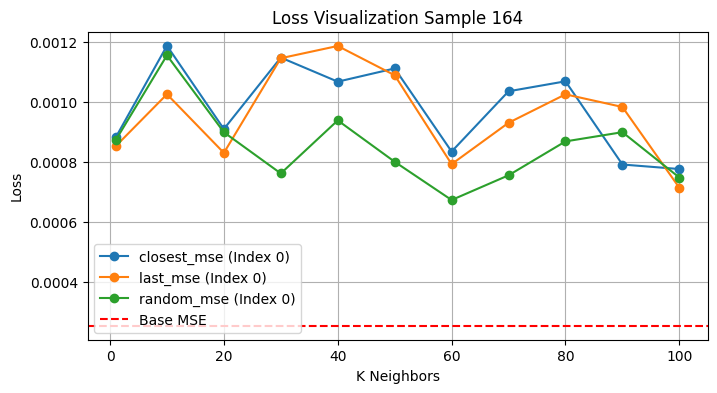

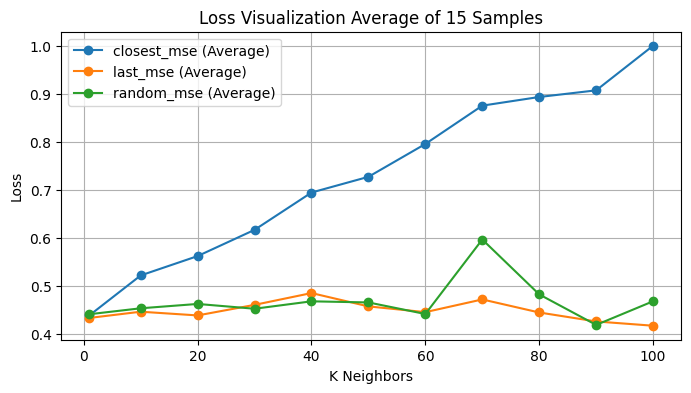

In [14]:
index_base = random_indices[0]
index_pos = random_indices.index(index_base)
predictions_base_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index_base)
base_error = nn.MSELoss()(predictions_base_rgb, sample_targets_rgb)

max_knn = 100  # Set a maximum K value for visualization

# Limit plotted K values by max_knn (e.g., 10) instead of positional max_points
visualize_results(mse_results, random_indices, selected_index=index_pos, base_mse=base_error, normalize=False, title=f"Loss Visualization Sample {index_base}", ylabel="Loss", max_knn=max_knn)
visualize_results(mse_results, list_of_indices, average=True, normalize=True, title=f"Loss Visualization Average of {len(random_indices)} Samples", max_knn=max_knn)

1: min=0.718206  max=5.30699  avg=2.25644
10: min=4.68908  max=12.684  avg=7.20007
20: min=6.52932  max=15.3219  avg=9.36931
30: min=7.26137  max=17.1178  avg=11.0283
40: min=8.15779  max=19.6158  avg=12.5077
50: min=8.96806  max=21.2969  avg=13.7414
60: min=9.44661  max=22.8059  avg=14.7882
70: min=10.0971  max=24.3181  avg=15.72
80: min=10.894  max=25.433  avg=16.5789
90: min=11.3223  max=26.3027  avg=17.37
100: min=11.6625  max=27.3285  avg=18.1075


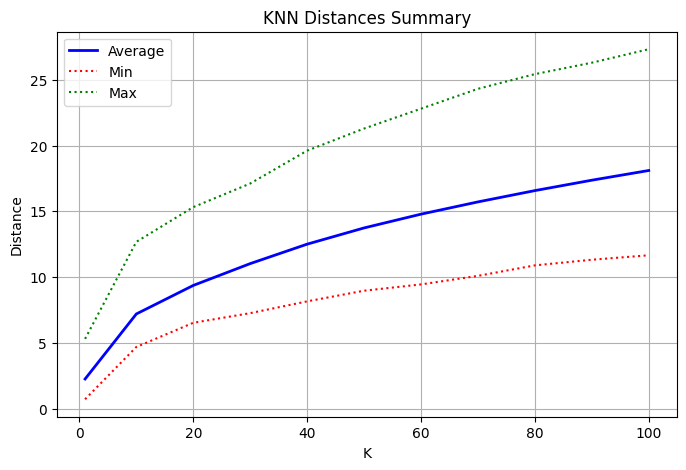

In [15]:
import statistics as stats

closest = knn_distances['closest_distances']  # your dict

def flatten_one_level(x):
    if not x:
        return []
    if isinstance(x[0], (list, tuple)):
        out = []
        for sub in x:
            if isinstance(sub, (list, tuple)):
                out.extend(sub)
            else:
                out.append(sub)
        return out
    return x

summary = {}
for k, v in closest.items():
    vals = flatten_one_level(v)
    if vals:  # skip empty
        summary[k] = {
            "min": min(vals),
            "max": max(vals),
            "avg": stats.fmean(vals),  # numerically robust mean
        }

# Example: print nicely, sorted by key
for k in sorted(summary):
    s = summary[k]
    print(f"{k}: min={s['min']:.6g}  max={s['max']:.6g}  avg={s['avg']:.6g}")
    
# Sort by keys
x = sorted(summary.keys())
y_min = [summary[k]["min"] for k in x]
y_max = [summary[k]["max"] for k in x]
y_avg = [summary[k]["avg"] for k in x]

plt.figure(figsize=(8,5))

# Plot avg as solid line
plt.plot(x, y_avg, label="Average", color="blue", linewidth=2)

# Plot min and max as dotted lines
plt.plot(x, y_min, label="Min", color="red", linestyle="dotted")
plt.plot(x, y_max, label="Max", color="green", linestyle="dotted")

plt.title("KNN Distances Summary")
plt.xlabel("K")
plt.ylabel("Distance")
plt.legend()
plt.grid(True)
plt.show()    